## Instalación y carga de librerías

In [ ]:
# Instalación (si fuera necesario) y carga de librerías
if (!require(triangle)) install.packages("triangle")
library(tidyverse)
library(lubridate)
library(triangle)

Loading required package: triangle

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Lectura de datos

In [ ]:
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Se realiza la simulación Monte Carlo con una semilla para reproducibilidad

### Se crea la variable de inversión CAPEX con una distribución triangular y la variable de ratio de descuento WACC con una distribución uniforme

Se simula el CAPEX y el WACC para 1000 escenarios. Para el Wacc se deciden 1000 escenarios entre 4,2% y 10 % Para el Capex se tomaron 1000 escenarios con un costo inicial de entre 2230 a 4150 dolares por KW.

In [ ]:
set.seed(1995)
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  CAPEX = rtriangle(1000, 2230, 4150, 3190),
  WACC = runif(1000, 0.04, 0.1)
)

In [ ]:
Scenarios <- DB_rad |>
  group_by(id) |>
  mutate(year = year(date), Output = (value / 1000) * 0.153 * 6.455) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), .groups = 'drop') |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(t = year - 2020, FDf = yearlyoutput / (1 + WACC)^t) |>
  group_by(id, CAPEX, WACC) |>
  summarise(VPf = sum(FDf), .groups = 'drop') |>
  mutate(LCOE = (CAPEX / VPf) * 1000)

In [ ]:
# Agrupar por WACC y calcular el promedio del LCOE
LCOE_avg <- Scenarios |>
  group_by(WACC) |>
  summarise(LCOE_mean = mean(LCOE), .groups = "drop") |>
  arrange(WACC)

In [ ]:
# Calcular la probabilidad de que LCOE_mean sea menor que 271 US$/MWh
probabilidad_menor_residencial <- mean(LCOE_avg$LCOE_mean < 271)

# Mostrar el resultado
print(paste("La probabilidad de que el LCOE sea menor que 271 US$/MWh es:", round(probabilidad_menor_residencial * 100, 2), "%"))


[1] "La probabilidad de que el LCOE sea menor que 271 US$/MWh es: 79.9 %"


###Visualización del LCOE

Se visualiza la relación entre cada perfil simulado y el LCOE correspondiente

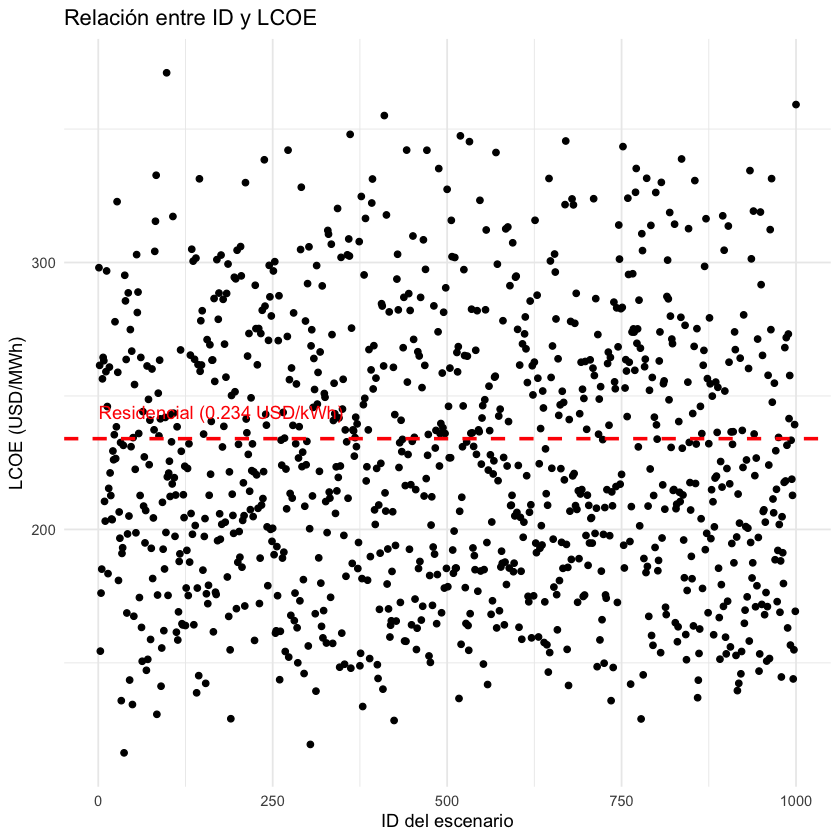

In [ ]:
ggplot(Scenarios, aes(id, LCOE), linewidth = 8) +
  geom_point() +
  geom_hline(yintercept = 234, color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = 1, y = 244, label = "Residencial (0.234 USD/kWh)", color = "red", hjust = 0) +
  labs(title = "Relación entre ID y LCOE", x = "ID del escenario", y = "LCOE (USD/MWh)") +
  theme_minimal()

Se mide kcuanto influye el cambio del CApex en el LCOE

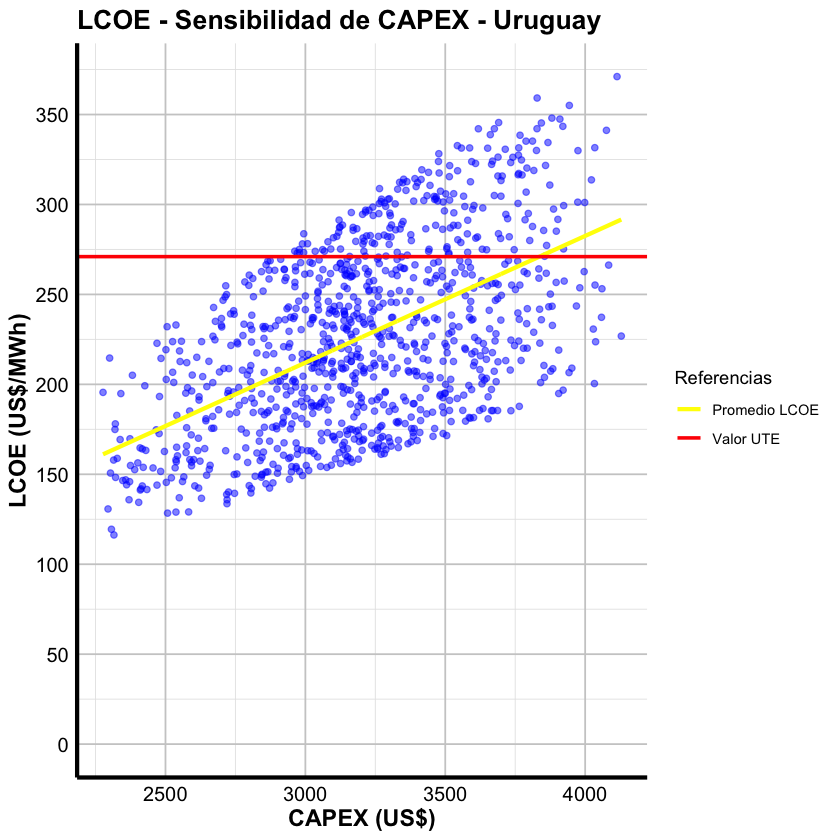

In [ ]:
# Ajustar un modelo de regresión lineal a los datos
modelo_LCOE <- lm(LCOE ~ CAPEX, data = Scenarios)

# Crear datos para la línea de tendencia basada en la pendiente promedio
Scenarios <- Scenarios |>
  mutate(LCOE_trend = predict(modelo_LCOE, newdata = Scenarios))

# Graficar LCOE en función del CAPEX con ejes resaltados y título en negrita
ggplot(Scenarios, aes(x = CAPEX, y = LCOE)) +
  geom_point(color = "blue", alpha = 0.5) +
  geom_line(aes(y = LCOE_trend, color = "Promedio LCOE"), size = 1.2) +
  geom_hline(aes(yintercept = 271, color = "Valor UTE"), size = 1) +
  scale_color_manual(
    name = "Referencias",
    values = c("Valor UTE" = "red", "Industrial" = "green", "Promedio LCOE" = "yellow")
  ) +
  scale_y_continuous(
    breaks = seq(0, max(Scenarios$LCOE, 300), 50),
    limits = c(0, NA)
  ) +
  labs(
    x = "CAPEX (US$)",
    y = "LCOE (US$/MWh)",
    title = "LCOE - Sensibilidad de CAPEX - Uruguay"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", color = "black"),  # Título en negrita
    axis.line = element_line(color = "black", linewidth = 1.2),
    axis.text = element_text(size = 12, color = "black"),
    axis.title = element_text(size = 14, face = "bold", color = "black"),
    panel.grid.major = element_line(color = "grey80"),
    panel.grid.minor = element_line(color = "grey90")
  )


### Se estudian diferentes escenarios con las variables involucradas


Probabilidaes de valores de WACC y de CAPEX

In [ ]:

# Probabilidad de que WACC sea menor a 8%
prob_wacc_1 <- mean(Par_MonteCarlo$WACC < 0.05) * 100
prob_wacc_2 <- mean(Par_MonteCarlo$WACC < 0.08) * 100
prob_wacc_3 <- mean(Par_MonteCarlo$WACC < 0.095) * 100
prob_wacc_4 <- mean(Par_MonteCarlo$WACC < 0.097) * 100

# Probabilidad de que CAPEX sea menor a 3190
prob_capex_1 <- mean(Par_MonteCarlo$CAPEX < 2500) * 100
prob_capex_2 <- mean(Par_MonteCarlo$CAPEX < 3190) * 100
prob_capex_3 <- mean(Par_MonteCarlo$CAPEX < 3800) * 100
prob_capex_4 <- mean(Par_MonteCarlo$CAPEX < 4000) * 100

# Mostrar resultados
cat(sprintf("Probabilidad de que WACC sea menor a 6.0%%: %.2f%%\n", prob_wacc_1))
cat(sprintf("Probabilidad de que WACC sea menor a 8.0%%: %.2f%%\n", prob_wacc_2))
cat(sprintf("Probabilidad de que WACC sea menor a 9.5%%: %.2f%%\n", prob_wacc_3))
cat(sprintf("Probabilidad de que WACC sea menor a 9.7%%: %.2f%%\n", prob_wacc_4))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 2500: %.2f%%\n", prob_capex_1))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 3190: %.2f%%\n", prob_capex_2))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 3800: %.2f%%\n", prob_capex_3))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 4000: %.2f%%\n", prob_capex_4))

Probabilidad de que WACC sea menor a 6.0%: 16.20%
Probabilidad de que WACC sea menor a 8.0%: 65.20%
Probabilidad de que WACC sea menor a 9.5%: 91.20%
Probabilidad de que WACC sea menor a 9.7%: 93.70%
Probabilidad de que CAPEX sea menor a USD 2500: 4.20%
Probabilidad de que CAPEX sea menor a USD 3190: 50.00%
Probabilidad de que CAPEX sea menor a USD 3800: 93.60%
Probabilidad de que CAPEX sea menor a USD 4000: 98.80%


Promedio mensual de la radiación por Mes en el periodo simulado entre 2024 y 2044

Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 12 × 2
   month avg_radiation
   <fct>         <dbl>
 1 ene            6.77
 2 feb            6.12
 3 mar            5.08
 4 abr            3.67
 5 may            2.55
 6 jun            2.23
 7 jul            2.29
 8 ago            3.21
 9 set            3.62
10 oct            5.14
11 nov            6.49
12 dic            7.18


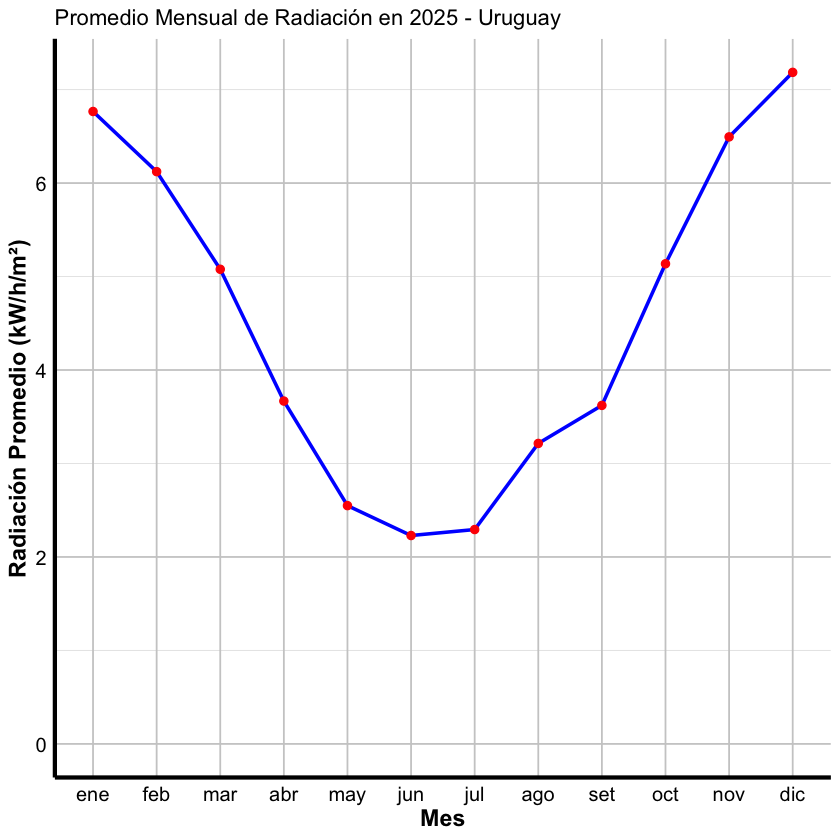

In [ ]:
# Cargar librerías necesarias
library(tidyverse)
library(lubridate)

# Cargar los datos de radiación
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Convertir la columna 'date' a formato de fecha
DB_rad <- DB_rad %>%
  mutate(date = as.Date(date, format="%Y-%m-%d"))

# Filtrar datos del año 2025
df_2025 <- DB_rad %>%
  filter(year(date) == 2025) %>%
  mutate(month = month(date, label = TRUE))

# Calcular el promedio mensual de radiación en kW/m²
monthly_radiation <- df_2025 %>%
  group_by(month) %>%
  summarise(avg_radiation = mean(value, na.rm = TRUE) / 1000)

# Reemplazar nombres de meses por versiones en español
meses_es <- c("ene", "feb", "mar", "abr", "may", "jun",
              "jul", "ago", "set", "oct", "nov", "dic")

monthly_radiation <- monthly_radiation %>%
  mutate(month = factor(meses_es[as.numeric(month)], levels = meses_es))

# Mostrar los resultados
print(monthly_radiation,show_col_types = FALSE)

# Graficar la radiación mensual en 2025 con eje Y comenzando en 0
ggplot(monthly_radiation, aes(x = month, y = avg_radiation, group = 1),) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 2) +
  labs(title = "Promedio Mensual de Radiación en 2025 - Uruguay",
       x = "Mes", y = "Radiación Promedio (kW/h/m²)") +
  ylim(0, NA) +  # <-- Asegura que el eje Y comience en 0
  theme_minimal() +
  theme(
    axis.line = element_line(color = "black", linewidth = 1.2),
    axis.text = element_text(size = 12, color = "black"),
    axis.title = element_text(size = 14, face = "bold", color = "black"),
    panel.grid.major = element_line(color = "grey80"),
    panel.grid.minor = element_line(color = "grey90")
  )


In [ ]:
set.seed(1995)
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  CAPEX = rtriangle(1000, 2230, 4150, 3190),
  WACC = runif(1000, 0.04, 0.1)
)

In [ ]:
install.packages("gridExtra")


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [ ]:
install.packages("patchwork")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Medición de la sensibilidad del LCOE respecto a la variación de la generación solar.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


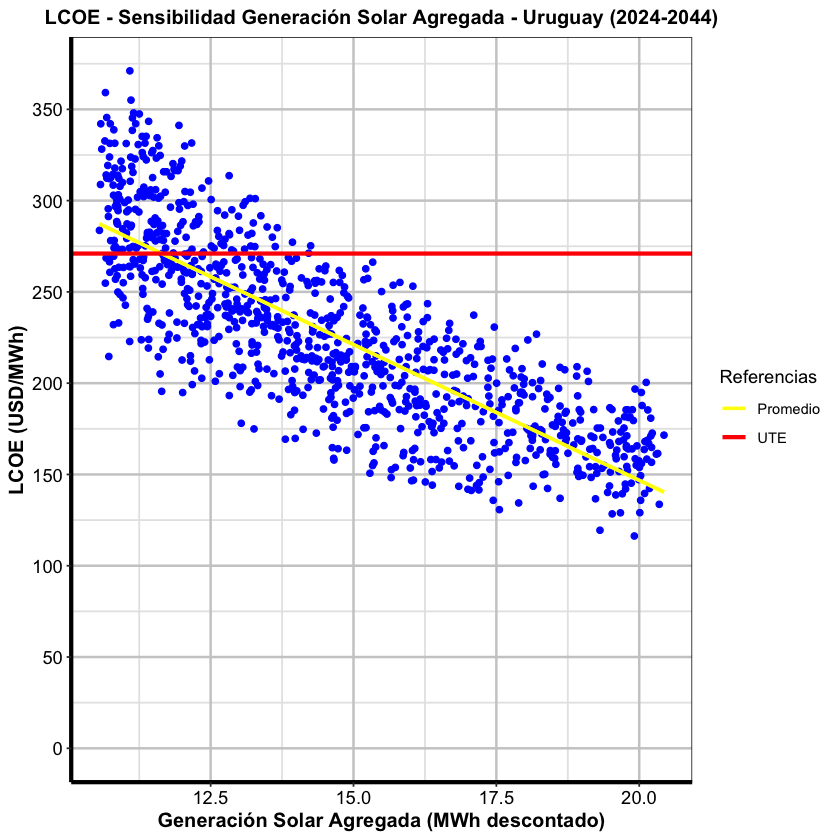

In [ ]:
# Gráfica con cuadrícula visible y ejes resaltados
Scenarios %>%
  ggplot(aes(VPf / 1000, LCOE)) +
  geom_point(color = "blue") +
  geom_smooth(method = "lm", se = FALSE, color = "yellow") +
  geom_smooth(aes(linetype = "Promedio", color = "Promedio"), method = "lm", se = FALSE) +
  geom_hline(aes(yintercept = 271, linetype = "UTE", color = "UTE"), size = 1.2) +
  scale_linetype_manual(
    name = "Referencias",
    values = c("UTE" = "solid", "Promedio" = "solid")
  ) +
  scale_color_manual(
    name = "Referencias",
    values = c("UTE" = "red", "Promedio" = "yellow")
  ) +
  scale_y_continuous(
    breaks = seq(0, max(Scenarios$LCOE, 400), 50),
    limits = c(0, NA)
  ) +
  labs(
    x = "Generación Solar Agregada (MWh descontado)",
    y = "LCOE (USD/MWh)",
    title = "LCOE - Sensibilidad Generación Solar Agregada - Uruguay (2024-2044)"
  ) +
  theme_bw() +  # Tema con cuadrícula de fondo
  theme(
    panel.grid.major = element_line(color = "grey80", linewidth = 0.7),  # Cuadrícula principal visible
    panel.grid.minor = element_line(color = "grey90", linewidth = 0.5),  # Cuadrícula secundaria visible
    axis.line = element_line(color = "black", linewidth = 1.2),          # Ejes claramente marcados
    axis.title = element_text(size = 12, face = "bold", color = "black"),
    axis.text = element_text(size = 11, color = "black"),
    plot.title = element_text(size = 12, face = "bold", hjust = 0.5)
  )


In [ ]:
######## 26/05/25

Distribución del LCOE en base a las simulaciones generadas

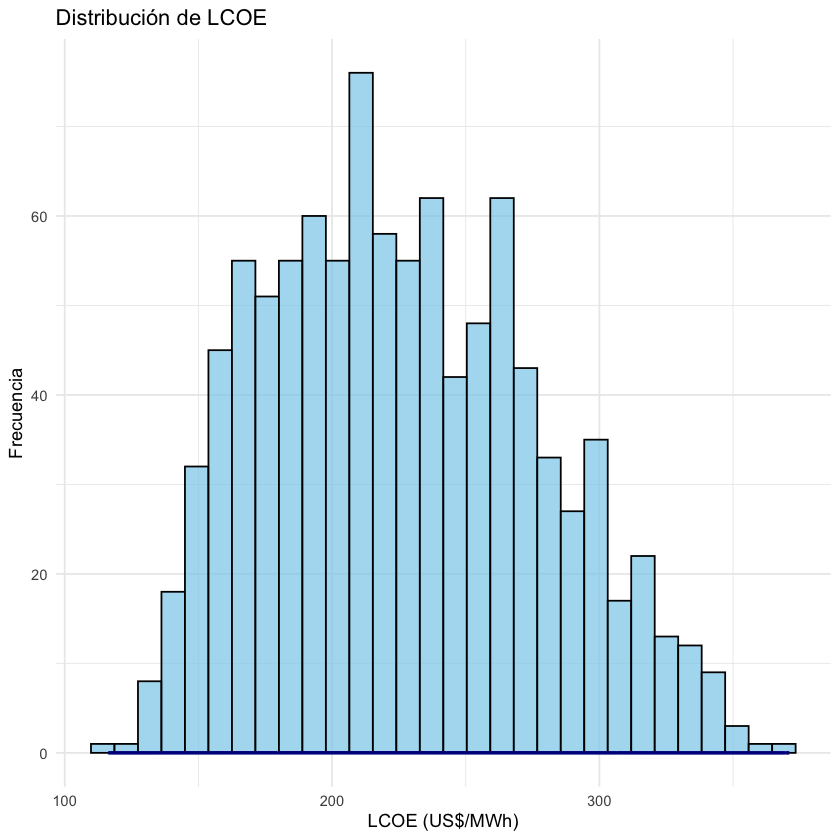

In [ ]:
library(ggplot2)

ggplot(Scenarios, aes(x = LCOE)) +
  geom_histogram(bins = 30, fill = "skyblue", color = "black", alpha = 0.7) +
  geom_density(color = "darkblue", size = 1) +
  labs(title = "Distribución de LCOE", x = "LCOE (US$/MWh)", y = "Frecuencia") +
  theme_minimal()

In [ ]:
colnames(Scenarios)

[1] "id"         "CAPEX"      "WACC"       "VPf"        "LCOE"      
[6] "LCOE_trend"

### Relación de CAPEX y LCOE en referencia al WACC

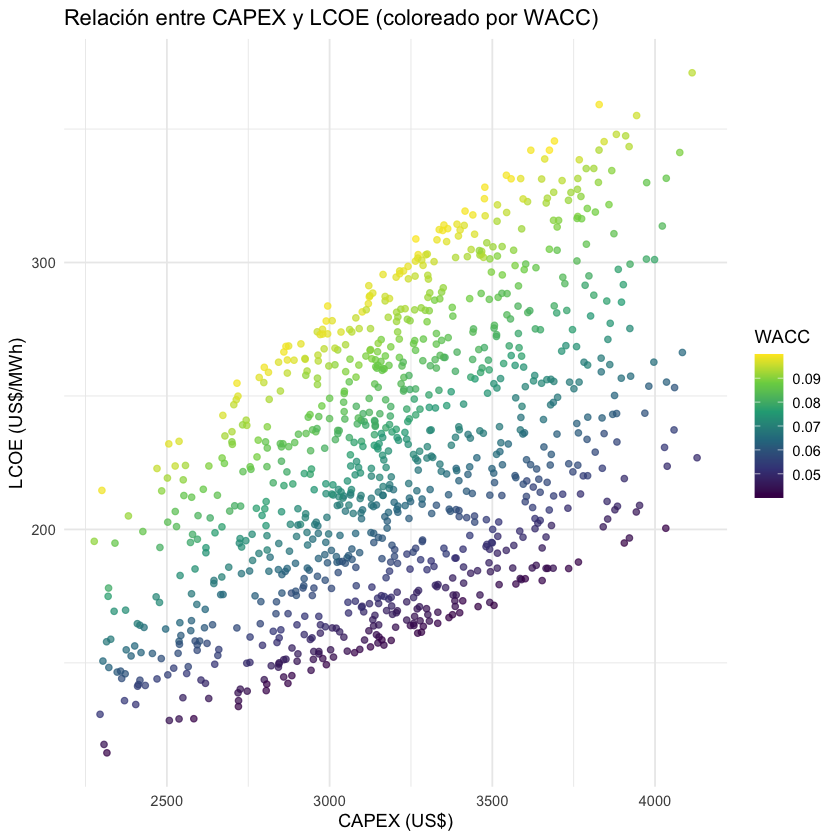

In [ ]:
library(tidyverse)  # Si no lo tienes ya cargado
# Renombrar las variables usando rename() de dplyr
library(dplyr)

ggplot(Scenarios, aes(x = CAPEX, y = LCOE, color = WACC)) +
  geom_point(alpha = 0.7) +
  scale_color_viridis_c() +
  labs(title = "Relación entre CAPEX y LCOE (coloreado por WACC)",
       x = "CAPEX (US$)", y = "LCOE (US$/MWh)") +
  theme_minimal()